# Lagrangian particle tracking

Material particles following ocean currents can be analyzed in terms of trajectories. These can simply be computed by integrating velocities through time within a [Lagrangian framework](https://en.wikipedia.org/wiki/Lagrangian_and_Eulerian_specification_of_the_flow_field). In `Julia` this is easily done using the [IndividualDisplacements.jl](https://JuliaClimate.github.io/IndividualDisplacements.jl/dev/) and [OrdinaryDiffEq.jl](https://docs.juliadiffeq.org/latest) packages.

## Import software, grid, and velocity fields

1. pre-requisites
2. read variables

In [1]:
#]add MITgcmTools#gfdev01; add OrdinaryDiffEq; add IndividualDisplacements#gfdev01;

In [2]:
using IndividualDisplacements, MeshArrays, OrdinaryDiffEq
using Plots, Statistics, MITgcmTools, DataFrames

include("helper_functions.jl")
get_grid_if_needed()
(uAll,vAll,γ) =read_velocity_and_grid()
γ=merge(γ,IndividualDisplacements.NeighborTileIndices_cs(γ));

## Pre-Process Gridded Variables

1. Select depth & time average
2. normalize to grid units
3. apply exchange function to `u,v,lon,lat`
4. store everything in a dictionary

In [3]:
k=20; 
u=similar(uAll[:,1,1]); v=similar(vAll[:,1,1]);
for i=1:size(uAll,1); for t=1:size(vAll,3);
        u[i]=u[i] + uAll[i,k,t] #select depth
        v[i]=v[i] + vAll[i,k,t]
end; end
u=u ./ size(uAll,3)
v=v ./ size(vAll,3) #time average
msk=(γ["hFacC"][:,k] .> 0.) #select depth

u[findall(isnan.(u))]=0.0; v[findall(isnan.(v))]=0.0 #mask with 0s rather than NaNs
u=u./γ["DXC"]; v=v./γ["DYC"]; #normalize to grid units

In [4]:
(u,v)=exchange(u,v,1) #add 1 point at each edge for u and v
XC=exchange(γ["XC"]) #add 1 lon point at each edge
YC=exchange(γ["YC"]) #add 1 lat point at each edge

t0=0.0; t1=86400*366*10.0; dt=10*86400.0;
uvt = Dict("u0" => u, "u1" => u, "v0" => v, "v1" => v,
    "t0" => t0, "t1" => t1, "dt" => dt, "msk" => msk)
uvetc=merge(uvt,γ); #store everything in a dictionary

## Initialize Trajectory Computation

1. set `duComp` to interpolation function
2. set `u0` initial location array

In [5]:
duComp=IndividualDisplacements.VelComp!
(u0,du)=initialize_locations(XC);

## Compute Trajectories

_Note: `ODEProblem` and `solve` settings can still be refined_

In [6]:
tspan = (0.0,uvt["t1"]-uvt["t0"])
prob = ODEProblem(duComp,u0,tspan,uvetc)
sol = solve(prob,Euler(),dt=uvt["dt"])
size(sol)

(3, 54408, 367)

## Post-Process Trajectories

1. Copy `sol` to a `DataFrame`
2. Map position to lon,lat coordinates

In [7]:
df=postprocess_locations(sol);

## Plot Trajectories


For example, you can:

- use either `Makie.jl` via `PlotMakie`
- or use `PyPlot.jl` via `PlotMapProj`


In [8]:
p=dirname(pathof(IndividualDisplacements));
#include(joinpath(p,"plot_pyplot.jl")); 
include(joinpath(p,"plot_makie.jl")); AbstractPlotting.inline!(true); #for Juno, set to false

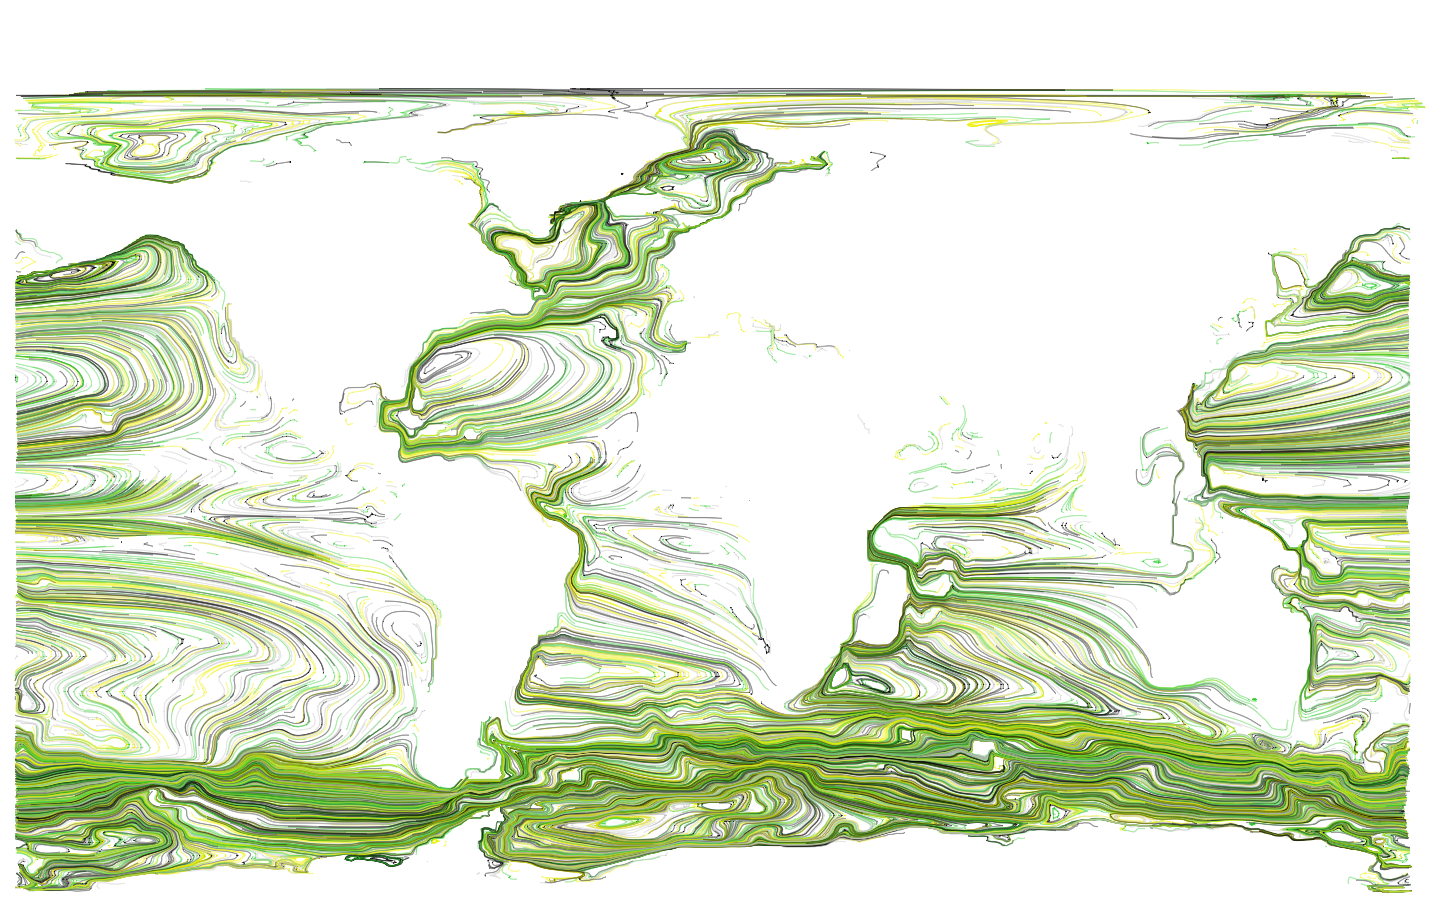

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /Users/gforget/.julia/packages/AbstractPlotting/MJWwh/src/display.jl:120


In [9]:
#PyPlot.figure(); PlotMapProj(df,5000)
scene=PlotMakie(df,5000,180.0) #Makie.save("LatLonCap300mDepth.png", scene)